## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing Necessary Libraries**

In [139]:
# installing the sentence-transformers and gensim libraries for word embeddings
# !pip install -U sentence-transformers gensim transformers tqdm -q

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# to use regular expressions for manipulating text data
import re

# To parse JSON data
import json

# to load the natural language toolkit
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')    # loading the stopwords
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

# to perform stemming
from nltk.stem.porter import PorterStemmer

# To build, tune, and evaluate ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# to create Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm.notebook import tqdm
tqdm.pandas()

# to split data into train and test sets
from sklearn.model_selection import train_test_split

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings(action='once')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohammadreza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mohammadreza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/opt/anaconda3/envs/great_learning/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## **Loading the dataset**

In [141]:
# Read a CSV file named "stock_news.csv" located in the current directory
stock_data = pd.read_csv("./stock_news.csv")

In [142]:
#Creating a copy of the dataset
stock = stock_data.copy()

## **Data Overview**

In [143]:
# Display the first five rows of the DataFrame
stock.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [144]:
# Get the dimensions of the DataFrame
stock.shape

(349, 8)

In [145]:
# Display a summary of the DataFrame
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


In [146]:
# Convert the 'Date' column in the DataFrame 'stock_data' to datetime format
stock["Date"] = pd.to_datetime(stock["Date"])

In [147]:
# Generate descriptive statistics for numerical columns in the DataFrame
stock.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,349,2019-02-16 16:05:30.085959936,2019-01-02 00:00:00,2019-01-14 00:00:00,2019-02-05 00:00:00,2019-03-22 00:00:00,2019-04-30 00:00:00,NaN
Open,349.0,46.229233,37.567501,41.740002,45.974998,50.7075,66.817497,6.442817
High,349.0,46.700458,37.817501,42.244999,46.025002,50.849998,67.0625,6.507321
Low,349.0,45.745394,37.305,41.482498,45.639999,49.7775,65.862503,6.391976
Close,349.0,44.926317,36.254131,40.246914,44.596924,49.11079,64.805229,6.398338
Volume,349.0,128948236.103152,45448000.0,103272000.0,115627200.0,151125200.0,244439200.0,43170314.918964
Label,349.0,-0.054441,-1.0,-1.0,0.0,0.0,1.0,0.715119


In [148]:
# Count the occurrences of each unique value in the 'Label' column of the DataFrame 'stock_data'
stock['Label'].value_counts()

Label
 0    170
-1     99
 1     80
Name: count, dtype: int64

In [149]:
# checking for duplicate values
stock.duplicated().sum()

0

In [150]:
# Count the number of missing (null) values in each column
stock.isnull().sum()

Date      0
News      0
Open      0
High      0
Low       0
Close     0
Volume    0
Label     0
dtype: int64

* There are no missing values in the DataFrame


## **Exploratory Data Analysis**

In [151]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [152]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        legend=False,
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

#### Observations on Label

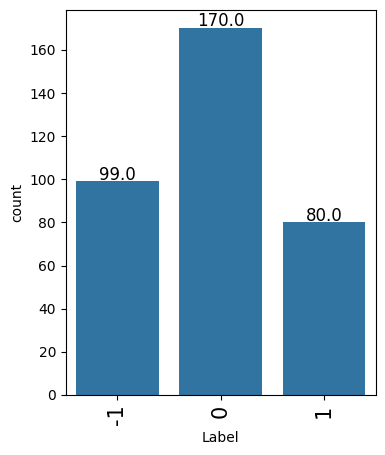

In [153]:
labeled_barplot(stock, 'Label')

* Nuetral news are almost twice the negative and positive news.

#### Histogram bar Plot of Price (Open,High,Low,Close)

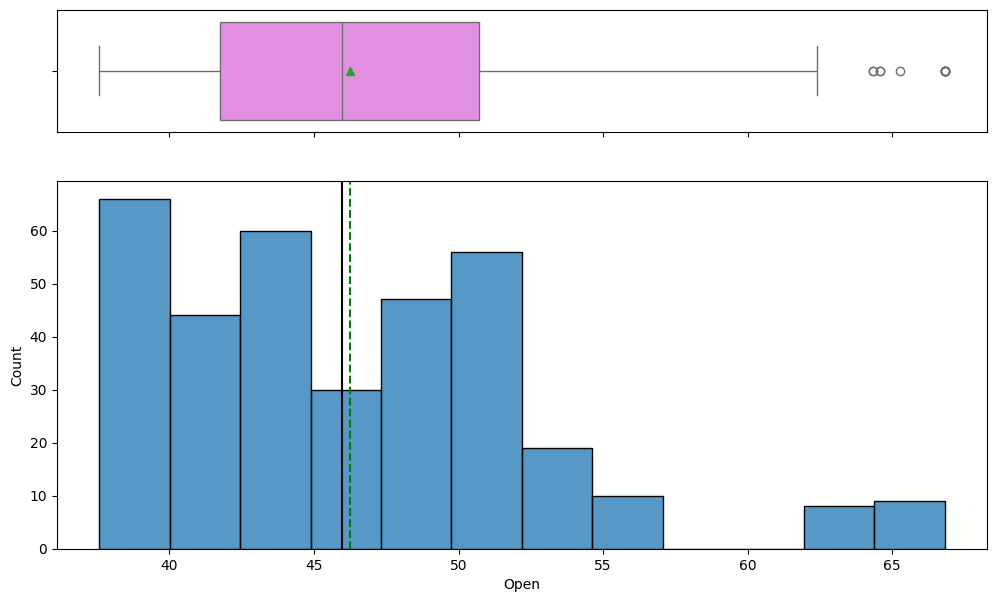

In [154]:
histogram_boxplot(stock, "Open")

* There are some right outlirers.

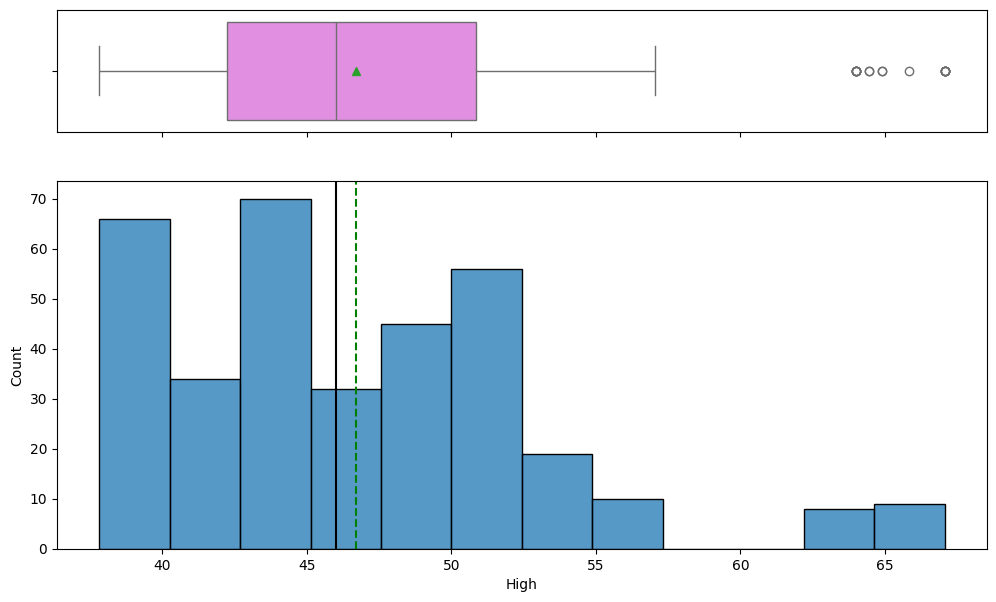

In [155]:
histogram_boxplot(stock, "High")

* There are some right outlirers.

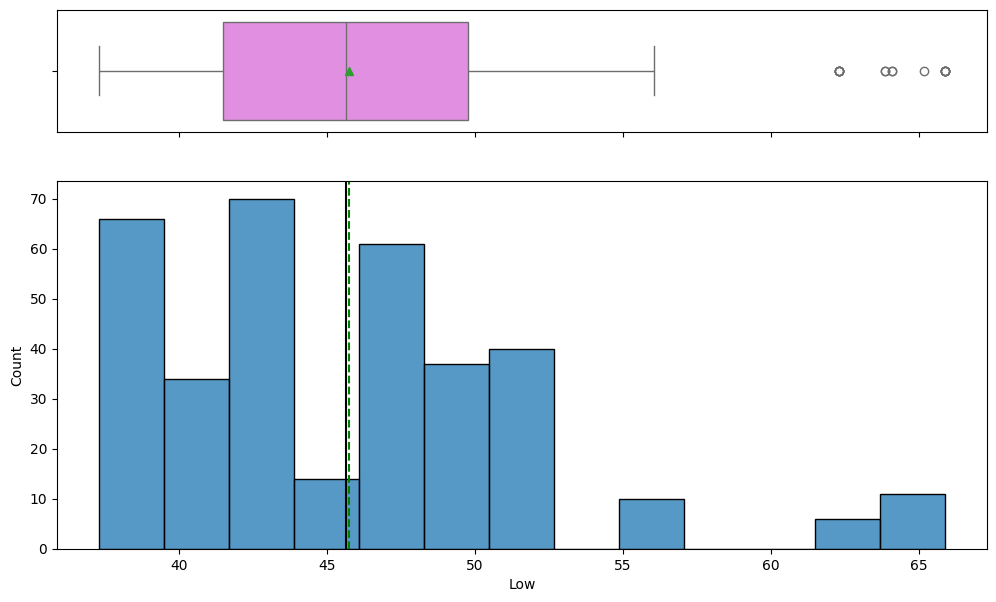

In [156]:
histogram_boxplot(stock, "Low")

* There are some right outlirers.

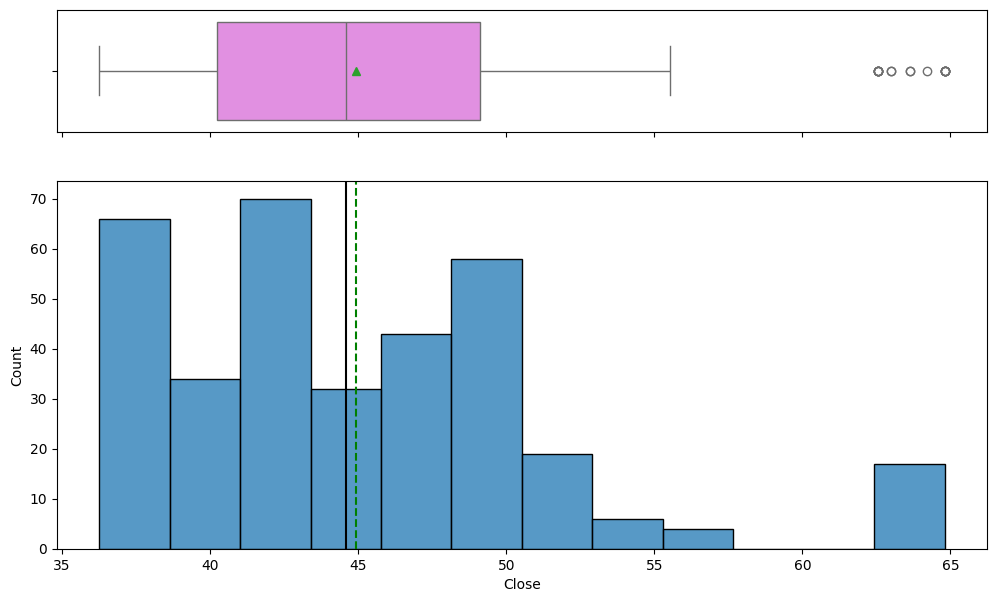

In [157]:
histogram_boxplot(stock, "Close")

* There are some right outlirers.

#### Observations on Volume

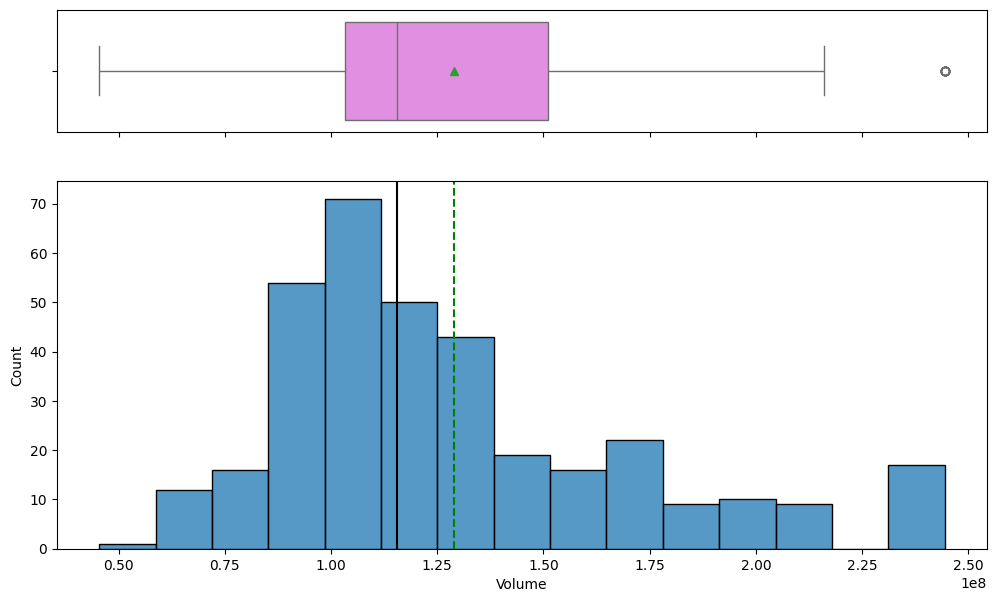

In [158]:
histogram_boxplot(stock, "Volume")

* Volume has almost a normal distribution

#### Observations on News length

In [159]:
stock['news_len'] = stock['News'].apply(len)
stock["news_len"].describe()

count    349.000000
mean     311.237822
std       39.079467
min      110.000000
25%      290.000000
50%      315.000000
75%      336.000000
max      394.000000
Name: news_len, dtype: float64

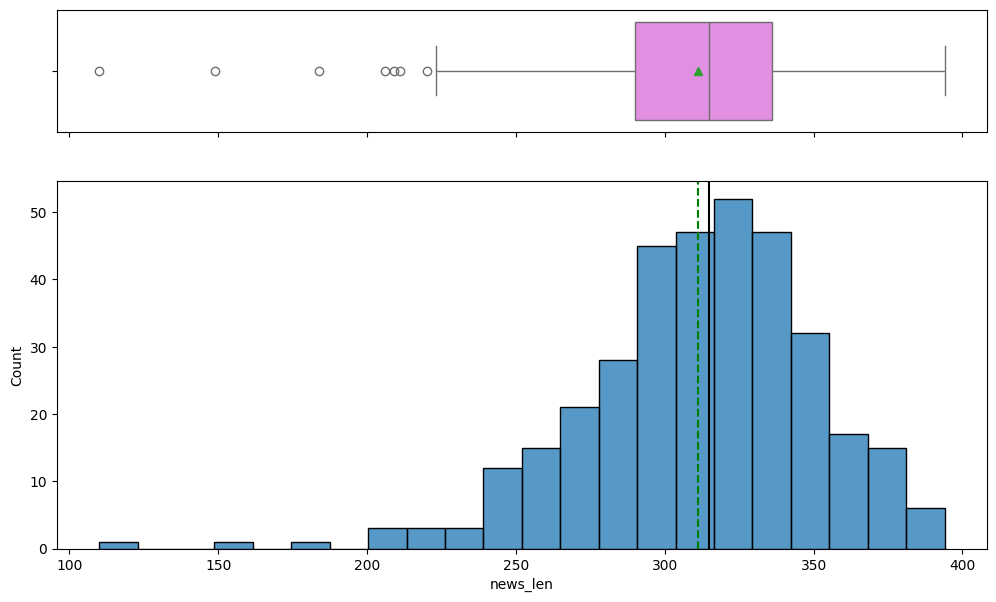

In [160]:
histogram_boxplot(stock, "news_len")

* News is left skewed.
* It has some left outlirers
* Mean and Median are around 310 characters

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

#### Correlation

<Axes: >

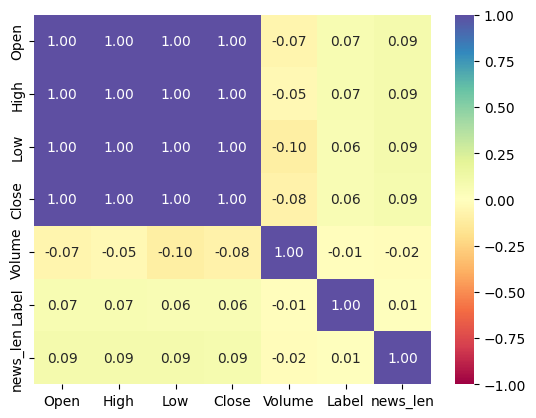

In [161]:
numeric_features = stock.select_dtypes(include=np.number).columns.to_list()
sns.heatmap(
    stock[numeric_features].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)

* There is a strong positive correlation between Open, Close, High and Low

#### Label vs Price (Open, High, Low, Close)

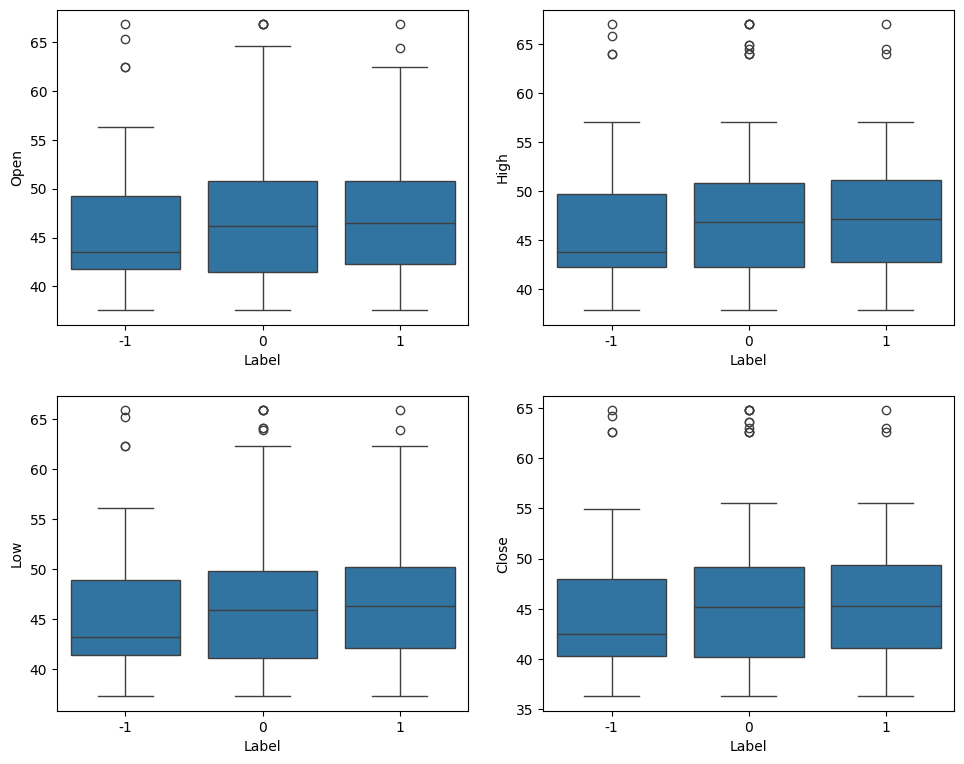

In [162]:
plt.figure(figsize=(10, 8))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=stock, x="Label", y=variable)
    plt.tight_layout(pad=2)

plt.show()

* On open, high, low, and close, Positive and Neutral have highest median compare to negative.



#### Label vs Volume

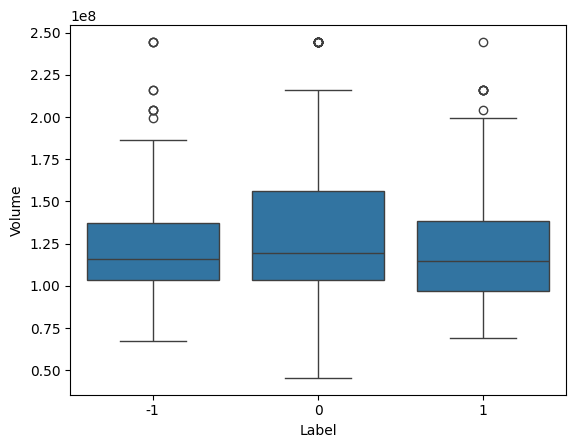

In [163]:
sns.boxplot(data=stock, x="Label",y="Volume");

* Neutral has higher median compare to negative and positive.

#### Date vs Price (Open, High, Low, Close)

In [164]:
stock_daily = stock.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()  # Group the 'stocks' DataFrame by the 'Date' column

stock_daily.set_index('Date', inplace=True)
stock_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,41.740002,42.244999,41.482498,40.246914,130672400.0
2019-01-03,43.570000,43.787498,43.222500,42.470604,103544800.0
2019-01-04,47.910000,47.919998,47.095001,46.419842,111448000.0
2019-01-07,50.792500,51.122501,50.162498,49.110790,109012000.0
2019-01-08,53.474998,54.507500,51.685001,50.787209,216071600.0


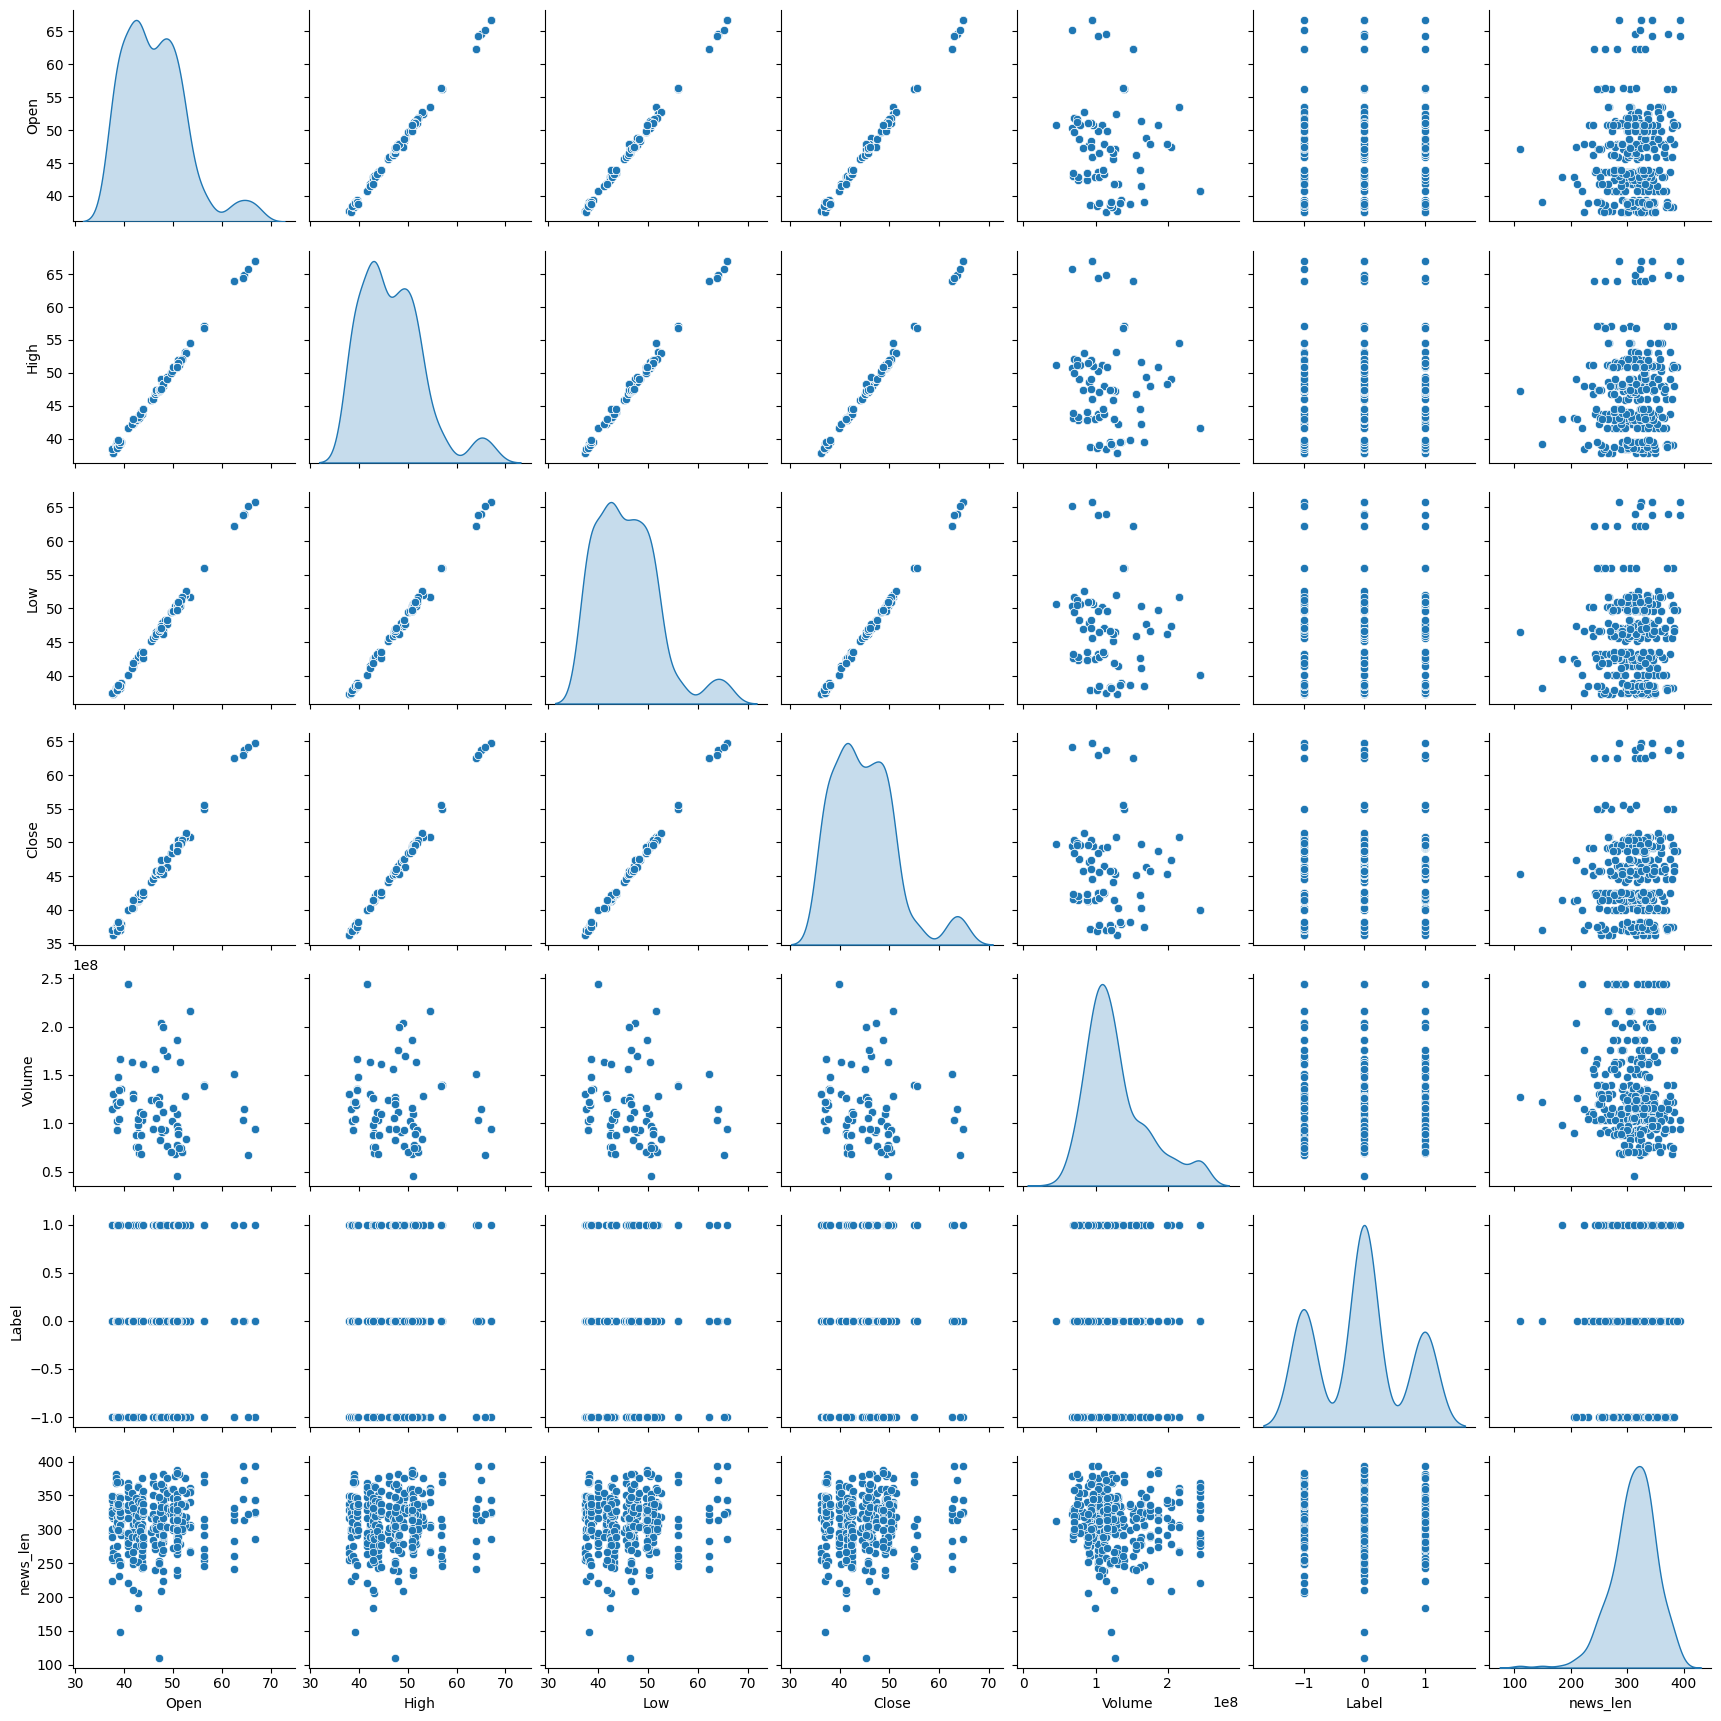

In [165]:
sns.pairplot(data=stock, diag_kind="kde")
plt.show()

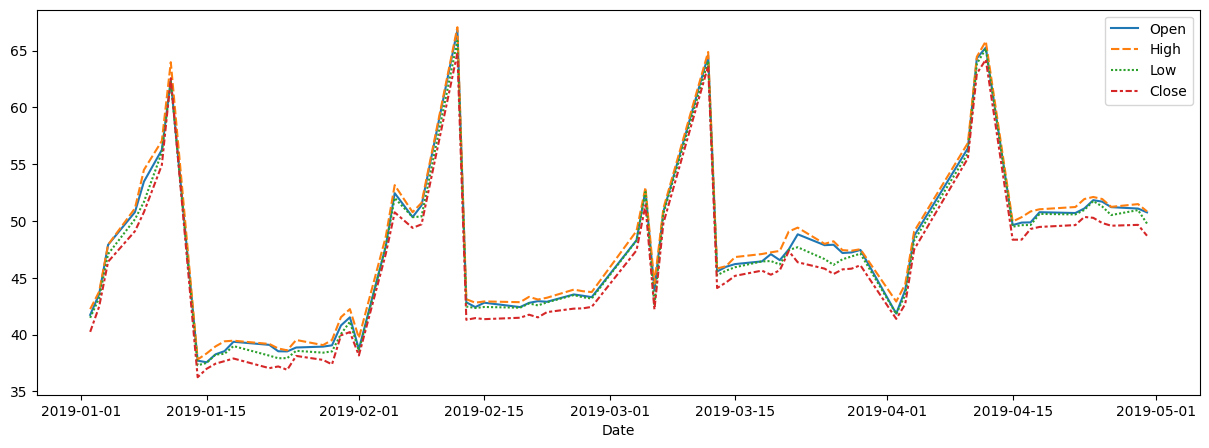

In [166]:
plt.figure(figsize=(15, 5))
sns.lineplot(stock_daily.drop("Volume", axis=1));

#### Volume vs Close Price

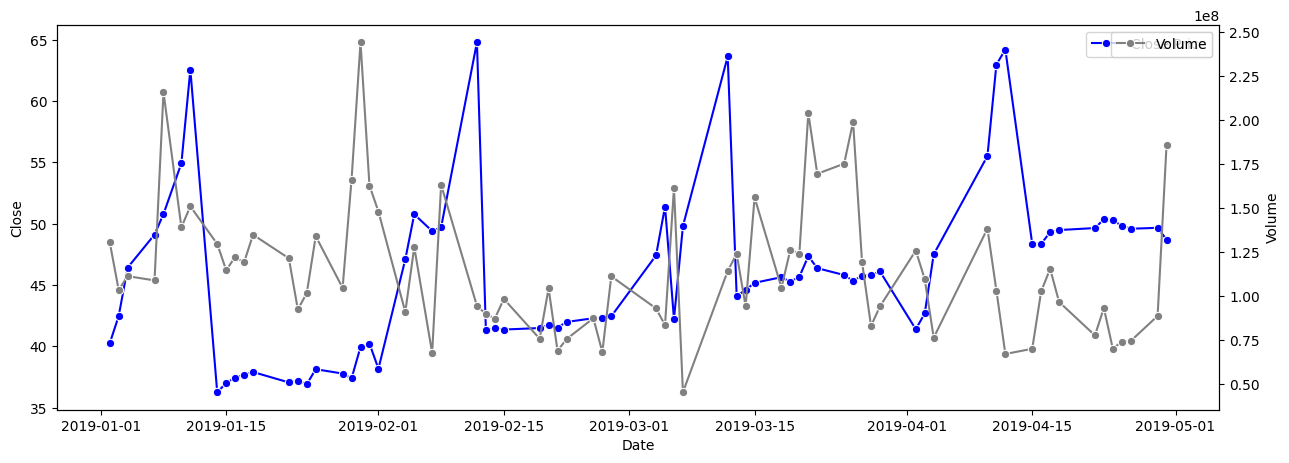

In [167]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15,5))

# Lineplot on primary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Close', ax=ax1, color='blue', marker='o', label='Close Price')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Lineplot on secondary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume')

ax1.legend(bbox_to_anchor=(1,1));

## Text Preprocessing

In [168]:
stock["Date"].describe()

count                              349
mean     2019-02-16 16:05:30.085959936
min                2019-01-02 00:00:00
25%                2019-01-14 00:00:00
50%                2019-02-05 00:00:00
75%                2019-03-22 00:00:00
max                2019-04-30 00:00:00
Name: Date, dtype: object

### Removing special characters from the text

In [169]:
# defining a function to remove special characters
def remove_special_characters(text):
    # Defining the regex pattern to match non-alphanumeric characters
    pattern = '[^A-Za-z0-9]+'

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = ''.join(re.sub(pattern, ' ', text))

    return new_text

In [170]:
# Applying the function to remove special characters
stock['cleaned_text'] = stock['News'].apply(remove_special_characters)

In [171]:
# checking a couple of instances of cleaned data
stock.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,The tech sector experienced a significant dec...,The tech sector experienced a significant dec...
1,Apple lowered its fiscal Q1 revenue guidance ...,Apple lowered its fiscal Q1 revenue guidance ...
2,Apple cut its fiscal first quarter revenue fo...,Apple cut its fiscal first quarter revenue fo...
3,This news article reports that yields on long...,This news article reports that yields on long...


### Lowercasing

In [172]:
# changing the case of the text data to lower case
stock['cleaned_text'] = stock['cleaned_text'].str.lower()

# checking a couple of instances of cleaned data
stock.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,The tech sector experienced a significant dec...,the tech sector experienced a significant dec...
1,Apple lowered its fiscal Q1 revenue guidance ...,apple lowered its fiscal q1 revenue guidance ...
2,Apple cut its fiscal first quarter revenue fo...,apple cut its fiscal first quarter revenue fo...
3,This news article reports that yields on long...,this news article reports that yields on long...


### Removing extra whitespace

In [173]:
# removing extra whitespaces from the text
stock['cleaned_text'] = stock['cleaned_text'].str.strip()

# checking a couple of instances of cleaned data
stock.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,The tech sector experienced a significant dec...,the tech sector experienced a significant decl...
1,Apple lowered its fiscal Q1 revenue guidance ...,apple lowered its fiscal q1 revenue guidance t...
2,Apple cut its fiscal first quarter revenue fo...,apple cut its fiscal first quarter revenue for...
3,This news article reports that yields on long...,this news article reports that yields on long ...


### Removing stopwords

In [174]:
# defining a function to remove stop words using the NLTK library
def remove_stopwords(text):
    # Split text into separate words
    words = text.split()

    # Removing English language stopwords
    new_text = ' '.join([word for word in words if word not in stopwords.words('english')])

    return new_text

In [175]:
# Applying the function to remove stop words using the NLTK library
stock['cleaned_text_without_stopwords'] = stock['cleaned_text'].apply(remove_stopwords)

In [176]:
# checking a couple of instances of cleaned data
stock.loc[0:3,['cleaned_text','cleaned_text_without_stopwords']]

,cleaned_text,cleaned_text_without_stopwords
0,the tech sector experienced a significant decl...,tech sector experienced significant decline af...
1,apple lowered its fiscal q1 revenue guidance t...,apple lowered fiscal q1 revenue guidance 84 bi...
2,apple cut its fiscal first quarter revenue for...,apple cut fiscal first quarter revenue forecas...
3,this news article reports that yields on long ...,news article reports yields long dated u treas...


### Stemming

Stemming is a language processing method that chops off word endings to find the root or base form of words.

For example,

- Original Word: Jumping, Stemmed Word: Jump
- Original Word: Running, Stemmed Word: Run

The Porter Stemmer is one of the widely-used algorithms for stemming, and it shorten words to their root form by removing suffixes.

In [177]:
# Loading the Porter Stemmer
ps = PorterStemmer()

In [178]:
# defining a function to perform stemming
def apply_porter_stemmer(text):
    # Split text into separate words
    words = text.split()

    # Applying the Porter Stemmer on every word of a message and joining the stemmed words back into a single string
    new_text = ' '.join([ps.stem(word) for word in words])

    return new_text

In [179]:
# Applying the function to perform stemming
stock['final_cleaned_text'] = stock['cleaned_text_without_stopwords'].apply(apply_porter_stemmer)

# checking a couple of instances of cleaned data
stock.loc[0:2,['cleaned_text_without_stopwords','final_cleaned_text']]

,cleaned_text_without_stopwords,final_cleaned_text
0,tech sector experienced significant decline af...,tech sector experienc signific declin aftermar...
1,apple lowered fiscal q1 revenue guidance 84 bi...,appl lower fiscal q1 revenu guidanc 84 billion...
2,apple cut fiscal first quarter revenue forecas...,appl cut fiscal first quarter revenu forecast ...


## Text Vectorization

In [180]:
# Initializing CountVectorizer with top 1000 words
bow_vec = CountVectorizer(max_features = 1000)

# Applying TfidfVectorizer on data
data_features_BOW = bow_vec.fit_transform(stock['final_cleaned_text'])

# Convert the data features to array
data_features_BOW = data_features_BOW.toarray()

# Shape of the feature vector
data_features_BOW.shape

(349, 1000)

In [181]:
# Getting the 1000 words considered by the BoW model
words = bow_vec.get_feature_names_out()

In [182]:
# Checking the words considered by BoW model
words

array(['000', '06', '10', '100', '11', '13', '14', '15', '16', '17', '18',
       '20', '200', '2014', '2016', '2017', '2018', '2019', '2020', '21',
       '24', '25', '26', '28', '30', '300', '31', '36', '3d', '44', '49',
       '50', '500', '54', '5g', '60', '600', '67', '737', '75', '800',
       '84', '89', '93', '99', 'aac', 'aapl', 'accept', 'access',
       'accord', 'account', 'accus', 'acknowledg', 'acquisit', 'across',
       'activ', 'ad', 'addit', 'address', 'adjust', 'administr', 'adopt',
       'advanc', 'advantag', 'advertis', 'advis', 'aetna', 'affair',
       'affect', 'agenc', 'agre', 'agreement', 'ahead', 'aid', 'aim',
       'air', 'airpod', 'album', 'alexa', 'alibaba', 'alleg', 'allegedli',
       'allow', 'along', 'alphabet', 'alreadi', 'also', 'am', 'amazon',
       'american', 'amid', 'amidst', 'amount', 'analyst', 'android',
       'announc', 'annual', 'anoth', 'answer', 'anticip', 'antitrust',
       'app', 'appeal', 'appear', 'appl', 'appli', 'applic', 'appro

In [183]:
# Creating a DataFrame from the data features
df_BOW = pd.DataFrame(data_features_BOW, columns=bow_vec.get_feature_names_out())
df_BOW.head()

,000,06,10,100,11,13,14,15,16,17,...,xr,year,yen,yet,yield,york,yoy,yuan,zeux,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## **Word Embeddings**

### Word2Vec

In [184]:
# creating a list of all words in our data
words_list = [item.split(" ") for item in stock['final_cleaned_text'].values]

In [185]:
# Checking the words from the first five reviews
words_list[0:5]

[['tech',
  'sector',
  'experienc',
  'signific',
  'declin',
  'aftermarket',
  'follow',
  'appl',
  'q1',
  'revenu',
  'warn',
  'notabl',
  'supplier',
  'includ',
  'skywork',
  'broadcom',
  'lumentum',
  'qorvo',
  'tsmc',
  'saw',
  'stock',
  'drop',
  'respons',
  'appl',
  'downward',
  'revis',
  'revenu',
  'expect',
  'quarter',
  'previous',
  'announc',
  'januari'],
 ['appl',
  'lower',
  'fiscal',
  'q1',
  'revenu',
  'guidanc',
  '84',
  'billion',
  'earlier',
  'estim',
  '89',
  '93',
  'billion',
  'due',
  'weaker',
  'expect',
  'iphon',
  'sale',
  'announc',
  'caus',
  'signific',
  'drop',
  'appl',
  'stock',
  'price',
  'neg',
  'impact',
  'relat',
  'supplier',
  'lead',
  'broader',
  'market',
  'declin',
  'tech',
  'indic',
  'nasdaq',
  '10'],
 ['appl',
  'cut',
  'fiscal',
  'first',
  'quarter',
  'revenu',
  'forecast',
  '89',
  '93',
  'billion',
  '84',
  'billion',
  'due',
  'weaker',
  'demand',
  'china',
  'fewer',
  'iphon',
  'upgr

In [186]:
# creating an instance of Word2Vec
model_W2V = Word2Vec(words_list, min_count = 1, workers = 6)

In [187]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 2580


In [188]:
# Checking the word embedding of a random word
word = "review"
model_W2V.wv[word]

array([-0.00411185, -0.00374359,  0.00299872, -0.00890941,  0.00357673,
        0.00072641, -0.00166555,  0.01146532,  0.00738763, -0.00608198,
       -0.0062028 , -0.00365043,  0.00761662,  0.01072067, -0.00778053,
        0.00259103,  0.006088  , -0.00770253,  0.00129195, -0.00356023,
        0.00309134,  0.00514482, -0.00431705, -0.0083381 ,  0.00565378,
       -0.00546406, -0.00518499, -0.00392107, -0.00970657,  0.00660036,
       -0.00225807, -0.00213294,  0.00309598,  0.00420274, -0.00035059,
        0.00097773, -0.00382429,  0.00639783, -0.00588438, -0.00364676,
        0.00872233,  0.0042837 , -0.01053732,  0.00784601,  0.01153405,
        0.00309483, -0.00723029,  0.00499442, -0.00386035, -0.00578636,
       -0.00218592, -0.00705641,  0.00859188,  0.00358623, -0.01240625,
       -0.00517621, -0.00768711, -0.00055467, -0.0088658 , -0.00437852,
        0.00821878,  0.00402192,  0.00021479, -0.00485466, -0.00873972,
        0.00288856,  0.00471076,  0.01088282, -0.00831975,  0.01

In [189]:
# Checking top 5 similar words to the word 'review'
similar = model_W2V.wv.similar_by_word('review', topn=5)
print(similar)

[('featur', 0.5058764815330505), ('weak', 0.4840131998062134), ('potenti', 0.48352596163749695), ('month', 0.47459733486175537), ('issu', 0.47064408659935)]


In [190]:
# Checking top 5 similar words to the word 'book'
similar = model_W2V.wv.similar_by_word('book', topn=5)
print(similar)

[('like', 0.4217619299888611), ('92', 0.39890187978744507), ('spotifi', 0.3959129750728607), ('investor', 0.3808131217956543), ('weak', 0.3736380636692047)]


In [191]:
# Dictionary with key as words and the value as the embedding vector.
words = model_W2V.wv.key_to_index

In [192]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(words[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [193]:
# creating a dataframe of the vectorized documents
vec_size = 100
df_word2vec = pd.DataFrame(stock['final_cleaned_text'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_word2vec

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 90,Feature 91,Feature 92,Feature 93,Feature 94,Feature 95,Feature 96,Feature 97,Feature 98,Feature 99
0,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250,...,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250,424.656250
1,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919,...,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919,194.918919
2,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000,...,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000,307.450000
3,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588,...,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588,255.970588
4,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143,...,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143,448.657143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519,...,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519,923.518519
345,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857,...,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857,547.942857
346,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649,...,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649,406.648649
347,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000,...,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000,341.725000


### GloVe

In [194]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = './glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [195]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(model.index_to_key))

Length of the vocabulary is 400000


In [196]:
# Checking the word embedding of a random word
word = "stock"
model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [197]:
#Returning the top 5 similar words.
result = model.most_similar("stock", topn=5)
print(result)

[('shares', 0.8525474667549133), ('stocks', 0.8309942483901978), ('market', 0.7991610765457153), ('exchange', 0.784952700138092), ('trading', 0.7632875442504883)]


In [198]:
#Returning the top 5 similar words.
result = model.most_similar("significant", topn=5)
print(result)

[('substantial', 0.8876033425331116), ('important', 0.8133977651596069), ('major', 0.7773129343986511), ('considerable', 0.7689315676689148), ('impact', 0.7590165734291077)]


In [199]:
#List of words in the vocabulary
words = model.index_to_key

In [200]:
#Dictionary with key as the word and the value as the corresponding embedding vector.
word_vector_dict = dict(zip(model.index_to_key,list(model.vectors)))

In [201]:
#Defining the dimension of the embedded vector.
vec_size=100

In [202]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [203]:
# creating a dataframe of the vectorized documents
df_glove = pd.DataFrame(stock['final_cleaned_text'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_glove

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 90,Feature 91,Feature 92,Feature 93,Feature 94,Feature 95,Feature 96,Feature 97,Feature 98,Feature 99
0,0.021671,0.096785,-0.047464,-0.066726,-0.215078,-0.603108,-0.089054,-0.001979,0.114239,-0.132121,...,-0.016118,0.282037,-0.146394,-0.217284,-0.137730,0.162514,0.208869,0.056668,0.186156,-0.025540
1,0.171825,0.341351,0.234650,-0.042054,-0.082840,-0.600302,-0.060674,-0.101788,-0.159387,0.023604,...,0.001762,0.271578,-0.190244,-0.136070,-0.442046,0.225178,0.175980,-0.036701,0.410090,-0.159631
2,0.010512,0.270341,0.301482,-0.087113,0.075485,-0.476547,-0.039534,-0.014161,-0.123561,-0.054536,...,0.113562,0.199301,-0.095302,-0.220799,-0.559601,0.130351,0.039756,-0.088995,0.484577,-0.204774
3,-0.147407,0.226970,0.377158,0.184659,-0.110523,-0.447424,-0.103314,0.033698,-0.021951,-0.041905,...,0.031969,0.314802,-0.276519,0.034750,-0.347012,0.131816,0.201519,-0.220721,0.328415,-0.101222
4,0.040798,0.198312,0.071460,0.037332,-0.098294,-0.407203,-0.078844,-0.102327,-0.132380,-0.031861,...,0.041134,0.188611,-0.051261,-0.364269,-0.216124,0.242409,0.243280,-0.071136,0.173813,-0.131392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,-0.133417,0.058861,0.415255,-0.291097,0.051498,0.079182,0.057609,0.127537,-0.074177,-0.070428,...,0.306373,-0.166262,0.083386,-0.120771,-0.347820,0.049615,-0.054991,-0.299478,0.437251,0.188692
345,0.159967,0.246612,0.288849,0.093632,0.043483,-0.284527,-0.167188,-0.049947,-0.246812,-0.088806,...,0.042174,0.246746,-0.054319,-0.047361,-0.572373,0.368322,0.077437,0.020181,0.441181,0.015956
346,0.043433,0.127144,0.151791,-0.053902,-0.067352,-0.187623,-0.020754,0.138385,-0.354622,-0.084654,...,-0.066027,0.240859,-0.119884,-0.026659,-0.428011,0.054745,-0.025141,-0.129436,0.258558,-0.027775
347,-0.098248,0.090049,0.181622,-0.028409,-0.128997,-0.497643,-0.247336,-0.034014,-0.103773,-0.195073,...,0.012848,0.070933,-0.053851,-0.265540,-0.415342,0.111974,0.295720,-0.207213,0.378713,0.026234


### Scentence Transformer Embdeddings.

In [204]:
#Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [205]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [206]:
# encoding the dataset
embedding_matrix = model.encode(stock['News'], show_progress_bar=True, device=device)

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

In [207]:
# printing the shape of the embedding matrix
embedding_matrix.shape

(349, 384)

* Each news article has been converted to a 384-dimensional vector

In [208]:
# printing the embedding vector of the first review in the dataset
embedding_matrix[0]

array([-2.02312693e-03, -3.67734246e-02,  7.73542970e-02,  4.67134677e-02,
        3.25520970e-02,  2.10234825e-03,  4.32834812e-02,  3.95344608e-02,
        5.82280234e-02,  8.87515396e-03,  7.09636733e-02,  4.99076247e-02,
        6.46608621e-02, -4.97968635e-03, -1.30518824e-02, -2.98355687e-02,
       -8.91324319e-03, -7.82000348e-02, -2.17109192e-02, -5.24823107e-02,
       -5.14276549e-02, -3.30719501e-02, -3.32051665e-02,  4.18125577e-02,
        7.99547061e-02,  1.54092433e-02, -2.15781778e-02,  5.19439131e-02,
       -4.65799496e-02, -3.71371731e-02, -1.04225606e-01,  9.86078680e-02,
        5.21786660e-02,  3.46578844e-02,  1.48810148e-02, -4.47357353e-03,
        5.70117198e-02, -2.41722483e-02,  2.14048941e-02, -6.52145147e-02,
       -3.30645628e-02,  1.61960293e-02, -6.63141608e-02,  4.39943597e-02,
        3.82152945e-02, -4.86519374e-02,  1.62651893e-02, -4.02665623e-02,
       -3.34566110e-03,  3.20955776e-02, -3.91202420e-03, -1.26830125e-02,
        4.49699201e-02,  

## Data Preprocessing

### Train-test-validation Split

In [209]:
# Creating dependent and independent variables
X_word2vec = df_word2vec.copy()
X_glove = df_glove.copy()
X_tranformer = embedding_matrix.copy()
y = stock['Label']

In [210]:
def split(X,y):
    # Initial split into training (80%) and testing (20%)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

    # Further split the temporary set into validation (10%) and test (10%) sets
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

    return X_train,X_valid,X_test,y_train,y_valid,y_test

In [211]:
#Splitting the dataset.
X_train_word2vec,X_valid_word2vec,X_test_word2vec,y_train_word2vec,y_valid_word2vec,y_test_word2vec=split(X_word2vec,y)
X_train_glove,X_valid_glove,X_test_glove,y_train_glove,y_valid_glove,y_test_glove=split(X_glove,y)
X_train_tranformer,X_valid_tranformer,X_test_tranformer,y_train_tranformer,y_valid_tranformer,y_test_tranformer=split(X_tranformer,y)

In [212]:
print(X_train_tranformer.shape, X_test_tranformer.shape, X_valid_tranformer.shape)

(279, 384) (35, 384) (35, 384)


In [213]:
print(X_train_glove.shape, X_test_glove.shape, X_valid_glove.shape)

(279, 100) (35, 100) (35, 100)


In [214]:
print(X_train_tranformer.shape, X_valid_tranformer.shape, X_test_tranformer.shape)

(279, 384) (35, 384) (35, 384)


* Each news content has been converted to a 384-dimensional vector.

## **Sentiment Analysis**

### Model Evaluation Criterion

* I will use GradientBoost for model training
* Will use F1-Score for model evaluation as model is imbalance, F1-Score. The F1-Score will give us a better metric to avoid the model form being too biased toward a dominant class

In [215]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1, -1]  # Define the labels for the confusion matrix.
    sns.heatmap(
        cm,
        annot=True,
        fmt=".0f",
        cmap="Blues",
        xticklabels=label_list,
        yticklabels=label_list,
    )
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel("Actual")  # Label for the y-axis.
    plt.xlabel("Predicted")  # Label for the x-axis.
    plt.title("Confusion Matrix")  # Title of the plot.
    plt.show()  # Display the plot.

In [216]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred, average="weighted")  # Compute Recall.
    precision = precision_score(target, pred, average="weighted")  # Compute Precision.
    f1 = f1_score(target, pred, average="weighted")  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.


### Base Model - Word2Vec

In [217]:
# Building the model
base_wv = GradientBoostingClassifier(random_state=42)

# Fit the model
base_wv.fit(X_train_word2vec, y_train_word2vec)

GradientBoostingClassifier(random_state=42)

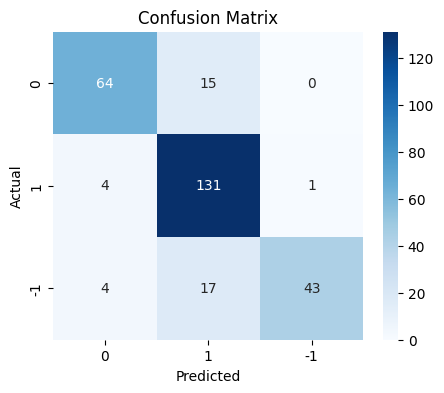

In [218]:
plot_confusion_matrix(base_wv, X_train_word2vec, y_train_word2vec)

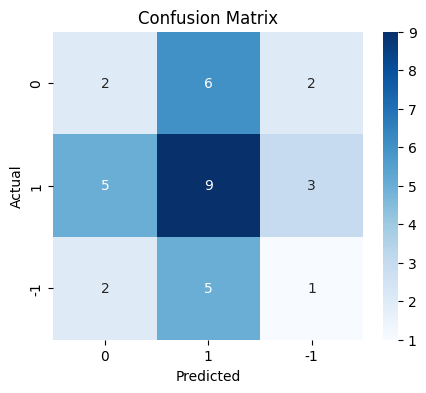

In [219]:
plot_confusion_matrix(base_wv, X_valid_word2vec, y_valid_word2vec)

In [220]:
#Calculating different metrics on training data
base_train_wv = model_performance_classification_sklearn(base_wv,X_train_word2vec,y_train_word2vec)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.853047  0.853047   0.867628  0.849822


In [221]:
#Calculating different metrics on validation data
base_val_wv = model_performance_classification_sklearn(base_wv,X_valid_word2vec,y_valid_word2vec)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.342857  0.342857   0.320159  0.329097


### Base Model - GloVe

In [222]:
from sklearn.base import clone
# base_wv = clone(base_wv)
base_wv = GradientBoostingClassifier(random_state=42)
# Fitting on train data
base_wv.fit(X_train_glove, y_train_glove)

GradientBoostingClassifier(random_state=42)

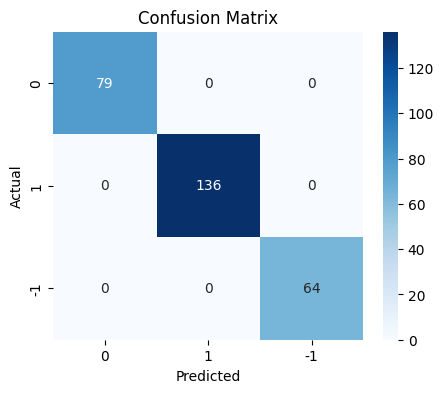

In [223]:
plot_confusion_matrix(base_wv, X_train_glove, y_train_glove)

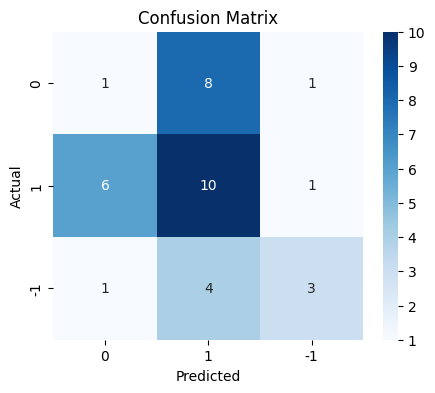

In [224]:
plot_confusion_matrix(base_wv, X_valid_glove, y_valid_glove)

In [225]:
# Calculating different metrics on training data
base_train_gl = model_performance_classification_sklearn(base_wv, X_train_glove, y_train_glove)
print("Training performance:\n", base_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [226]:
# Calculating different metrics on training data
base_val_gl = model_performance_classification_sklearn(base_wv, X_valid_glove, y_valid_glove) 
print("Val performance:\n", base_val_gl)

Val performance:
    Accuracy  Recall  Precision        F1
0       0.4     0.4   0.393636  0.386325


### Base Model - Sentence Transformer

In [227]:
# Building the model
base_wv = GradientBoostingClassifier(random_state=42)
base_wv.fit(X_train_tranformer, y_train_tranformer)

GradientBoostingClassifier(random_state=42)

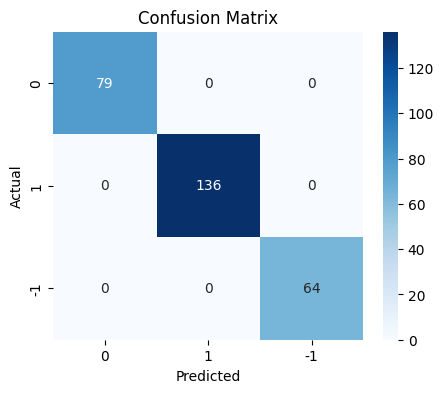

In [228]:
plot_confusion_matrix(base_wv, X_train_tranformer, y_train_tranformer)

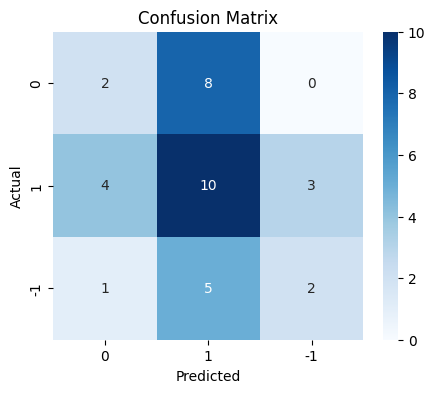

In [229]:
plot_confusion_matrix(base_wv, X_valid_tranformer, y_valid_tranformer)

In [230]:
# Calculating different metrics on training data
base_train_st = model_performance_classification_sklearn(base_wv, X_train_tranformer, y_train_tranformer)
print("Training performance:\n", base_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [231]:
# Calculating different metrics on training data
base_val_st = model_performance_classification_sklearn( base_wv, X_valid_tranformer, y_valid_tranformer)
print("Validaiotn performance:\n", base_val_st)

Validaiotn performance:
    Accuracy  Recall  Precision        F1
0       0.4     0.4   0.384241  0.380414


### Tuned Model - Word2Vec

In [232]:
start = time.time()
tuned_wv = clone(base_wv)

parameters = {
    "max_depth": np.arange(3, 7),
    "min_samples_split": np.arange(5, 12, 2),
    "max_features": ["log2", "sqrt", 0.2, 0.4],
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring="f1_weighted", cv=5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_word2vec, y_train_word2vec)

end = time.time()
print("Time taken ", (end - start))

# Set the clf to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

/opt/anaconda3/envs/great_learning/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=4094) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


Time taken  9.593179941177368


In [233]:
# Fit the best algorithm to the data.
tuned_wv.fit(X_train_word2vec, y_train_word2vec)

GradientBoostingClassifier(max_features='log2', min_samples_split=11,
                           random_state=42)

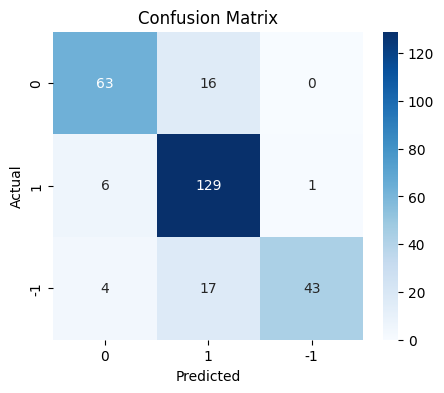

In [234]:
plot_confusion_matrix(tuned_wv, X_train_word2vec, y_train_word2vec)

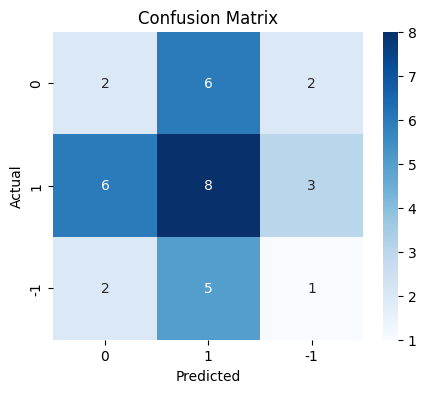

In [235]:
plot_confusion_matrix(tuned_wv, X_valid_word2vec, y_valid_word2vec)

In [236]:
# Calculating different metrics on training data
tuned_train_wv = model_performance_classification_sklearn(tuned_wv, X_train_word2vec, y_train_word2vec)
print("Training performance:\n", tuned_train_wv)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.842294  0.842294   0.856702  0.839408


In [237]:
# Calculating different metrics on validation data
tuned_val_wv = model_performance_classification_sklearn(tuned_wv, X_valid_word2vec, y_valid_word2vec)
print("Validation performance:\n", tuned_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.314286  0.314286   0.299749  0.305669


### Tuned Model - GloVe

In [238]:
start = time.time()


tuned_wv = GradientBoostingClassifier(random_state=42)

parameters = {
    "max_depth": np.arange(3, 7),
    "min_samples_split": np.arange(5, 12, 2),
    "max_features": ["log2", "sqrt", 0.2, 0.4],
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring="f1_weighted", cv=5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train_glove, y_train_glove)

end = time.time()
print("Time taken ", (end - start))

# Set the clf to the best combination of parameters
tuned_gl = grid_obj.best_estimator_

Time taken  11.89432692527771


In [239]:
# Fit the best algorithm to the data.
tuned_gl.fit(X_train_glove, y_train_glove)

GradientBoostingClassifier(max_depth=4, max_features='log2',
                           min_samples_split=11, random_state=42)

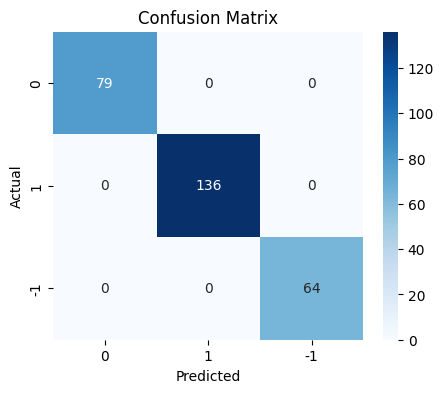

In [240]:
plot_confusion_matrix(tuned_gl, X_train_glove, y_train_glove)

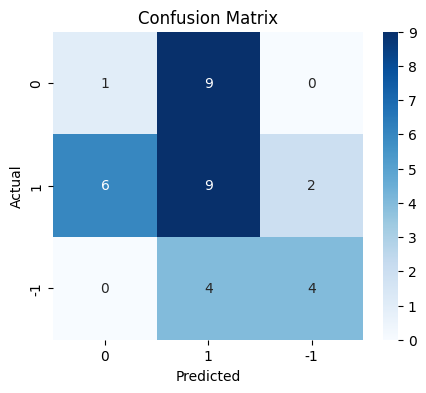

In [241]:
plot_confusion_matrix(tuned_gl, X_valid_glove, y_valid_glove)

In [242]:
# Calculating different metrics on training data
tuned_train_gl = model_performance_classification_sklearn(tuned_gl, X_train_glove, y_train_glove)
print("Training performance:\n", tuned_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [243]:
# Calculating different metrics on training data
tuned_val_gl = model_performance_classification_sklearn(tuned_gl, X_valid_glove, y_valid_glove)
print("Val performance:\n", tuned_val_gl)

Val performance:
    Accuracy  Recall  Precision        F1
0       0.4     0.4   0.391899  0.388402


### Tuned Model - Sentence Transformer

In [244]:
start = time.time()

tuned_wv = GradientBoostingClassifier(random_state=42)

parameters = {
    "max_depth": np.arange(3, 7),
    "min_samples_split": np.arange(5, 12, 2),
    "max_features": ["log2", "sqrt", 0.2, 0.4],
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring="f1_weighted", cv=5, n_jobs=-1) 
grid_obj = grid_obj.fit(X_train_tranformer, y_train_tranformer)

end = time.time()
print("Time taken ", (end - start))

# Set the clf to the best combination of parameters
tuned_st = grid_obj.best_estimator_

Time taken  27.310717821121216


In [245]:
# Fit the best algorithm to the data.
tuned_st.fit(X_train_tranformer, y_train_tranformer) 

GradientBoostingClassifier(max_depth=4, max_features='log2',
                           min_samples_split=11, random_state=42)

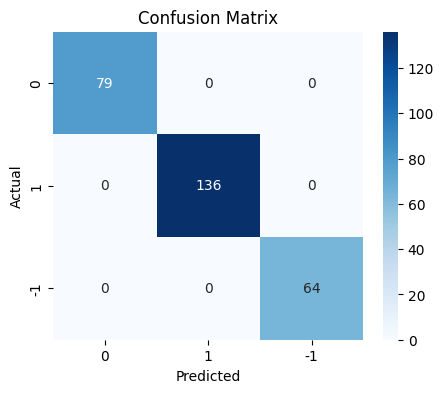

In [246]:
plot_confusion_matrix(tuned_st, X_train_tranformer, y_train_tranformer)

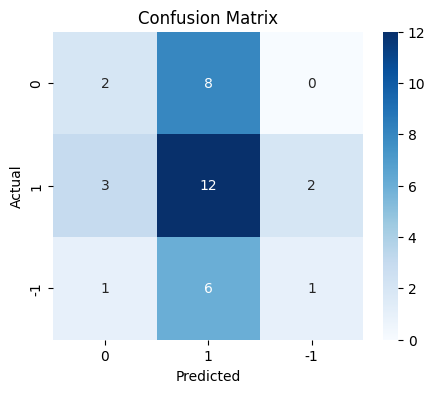

In [247]:
plot_confusion_matrix(tuned_st, X_valid_tranformer, y_valid_tranformer)

In [248]:
# Calculating different metrics on training data
tuned_train_st = model_performance_classification_sklearn(tuned_st, X_train_tranformer, y_train_tranformer) 
print("Training performance:\n", tuned_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [249]:
# Calculating different metrics on validation data
tuned_val_st = model_performance_classification_sklearn(tuned_st, X_valid_tranformer, y_valid_tranformer) 
print("Validation performance:\n", tuned_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.428571  0.428571   0.395604  0.384083


### Model Performance Summary and Final Model Selection

In [250]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        base_train_wv.T,
        base_train_gl.T,
        base_train_st.T,
        tuned_train_wv.T,
        tuned_train_gl.T,
        tuned_train_st.T,
    ],
    axis=1,
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,0.853047,1.0,1.0,0.842294,1.0,1.0
Recall,0.853047,1.0,1.0,0.842294,1.0,1.0
Precision,0.867628,1.0,1.0,0.856702,1.0,1.0
F1,0.849822,1.0,1.0,0.839408,1.0,1.0


In [251]:
# validation performance comparison

models_val_comp_df = pd.concat(
    [
        base_val_wv.T,
        base_val_gl.T,
        base_val_st.T,
        tuned_val_wv.T,
        tuned_val_gl.T,
        tuned_val_st.T,
    ],
    axis=1,
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,0.342857,0.400000,0.400000,0.314286,0.400000,0.428571
Recall,0.342857,0.400000,0.400000,0.314286,0.400000,0.428571
Precision,0.320159,0.393636,0.384241,0.299749,0.391899,0.395604
F1,0.329097,0.386325,0.380414,0.305669,0.388402,0.384083


### Model Performance Check on Test Data

* Tuned_gl has the best performance, with is slected to test

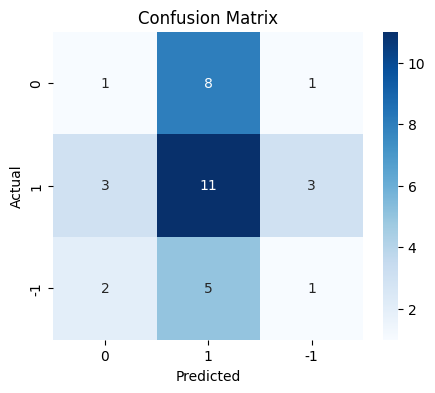

In [252]:
plot_confusion_matrix(tuned_gl, X_test_glove, y_test_glove)

In [253]:
#Calculating different metrics on training data
final_model_test = model_performance_classification_sklearn(tuned_gl, X_test_glove, y_test_glove) 
print("Test performance for the final model:\n",final_model_test)

Test performance for the final model:
    Accuracy    Recall  Precision        F1
0  0.371429  0.371429   0.315952  0.331506


* 33 for F1-Score is a littel below the performance in validation set. 

## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [2]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
# !CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python -q

/opt/anaconda3/envs/great_learning/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=2222) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [3]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

In [256]:
stock_news = pd.read_csv('./stock_news.csv') 
pd

In [257]:
data = stock_news.copy()

#### Loading the model

In [4]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"


model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename, )

In [5]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2,  # CPU cores
    n_batch=512,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    # n_gpu_layers=43,  # uncomment and change this value based on GPU VRAM pool.
    n_ctx=4096,  # Context window
)

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /Users/mohammadreza/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
lla

#### Aggregating the data weekly

In [260]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [261]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [262]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [263]:
weekly_grouped

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [264]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [265]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [266]:
llm = Llama(
    model_path=model_path,
    n_threads=2,  # CPU cores
    n_batch=512,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=43,  # Change this value based on your model and your GPU VRAM pool.
    n_ctx=4096,  # Context window
)

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /Users/mohammadreza/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
lla

In [267]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=1024, #Complete the code to set the maximum number of tokens the model should generate for this task.
      temperature=0.01, #Complete the code to set the value for temperature.
      top_p=0.95, #Complete the code to set the value for top_p
      top_k=50, #Complete the code to set the value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

In [268]:
news = data_1.loc[0, "News"]
news

' The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

In [269]:
print(len(news.split(' ')))
news

2611


' The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

In [270]:
prompt = """
Role: You are an expert financial analyst specializing in market trends and news analysis.

Task: Analyze the provided news articles or headlines and identify the top three positive and negative events that are most likely to impact the price of a stock.

Instructions:

Read and Understand: Carefully read each news article or headline.
Identify Key Events: Determine the most significant events or developments mentioned.
Assess Impact: Evaluate how these events are likely to affect the stock price, considering factors such as investor sentiment, market conditions, and company fundamentals.
Categorize: Classify the events as either positive or negative based on their anticipated impact on the stock price.
Prioritize: Rank the events in order of their perceived importance and potential influence on the stock price.
Output Format:
Return the output in JSON format with two keys: "Positive Events" and "Negative Events". Each key should contain a list of the top three events, ranked from most to least impactful.

"""

In [271]:
%%time
summary = response_mistral_1(prompt, news)
print(summary)

llama_perf_context_print:        load time =    9251.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  3980 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   115 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   13503.36 ms /  4095 tokens


 {
         "Positive Events": [
           {
             "description": "Roku Inc announced plans to offer premium video channels on a subscription basis through its free streaming service, The Roku Channel.",
             "impact": "This announcement could positively impact Roku's stock price as it follows Amazon's successful Channels business model and attracts more subscribers to its platform."
           },
           {
             "description": "The Chinese central bank announced a fifth reduction in the required reserve ratio (RRR) for banks,
CPU times: user 113 ms, sys: 116 ms, total: 229 ms
Wall time: 13.5 s


##### Checking the model output on the weekly data

In [272]:
%%time
data_1['Key Events'] = data_1['News'].progress_apply(lambda x: response_mistral_1(prompt,x))

  0%|          | 0/18 [00:00<?, ?it/s]Llama.generate: 3979 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =    9251.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   116 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    4291.23 ms /   117 tokens
 11%|█         | 2/18 [00:04<00:34,  2.15s/it]Llama.generate: 235 prefix-match hit, remaining 2234 prompt tokens to eval
llama_perf_context_print:        load time =    9251.56 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  2234 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   529 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   22625.31 ms /  2763 token

CPU times: user 7.17 s, sys: 1.08 s, total: 8.26 s
Wall time: 5min 30s


In [273]:
data_1['Key Events'].head()

0     {\n         "Positive Events": [\n           ...
1     {\n         "Positive Events": [\n           ...
2     {\n          "Positive Events": [\n          ...
3     {\n          "Positive Events": [\n          ...
4     {\n          "Positive Events": [\n          ...
Name: Key Events, dtype: object

##### Formatting the model output

In [274]:
data_1['model_response_parsed'] = data_1['Key Events'].apply(extract_json_data)
data_1.head()

Error parsing JSON: Expecting ',' delimiter: line 6 column 13 (char 421)
Error parsing JSON: Expecting ',' delimiter: line 77 column 15 (char 4132)


,Date,News,Key Events,model_response_parsed
0,2019-01-06,The tech sector experienced a significant dec...,"{\n ""Positive Events"": [\n ...",{}
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,"{\n ""Positive Events"": [\n ...",{'Positive Events': [{'description': 'Sprint a...
2,2019-01-20,The U.S. stock market declined on Monday as c...,"{\n ""Positive Events"": [\n ...",{'Positive Events': [{'description': 'Apple's ...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...","{\n ""Positive Events"": [\n ...",{'Positive Events': [{'Event': 'IBM's stock pr...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,"{\n ""Positive Events"": [\n ...",{'Positive Events': [{'event': 'Apple reported...


In [275]:
model_response_parsed = pd.json_normalize(data_1['model_response_parsed'])
model_response_parsed.head()

,Positive Events,Negative Events
0,NaN,NaN
1,[{'description': 'Sprint and Samsung plan to r...,[{'description': 'Geely forecasts flat sales f...
2,[{'description': 'Apple's stock price rose aft...,[{'description': 'U.S. stocks declined followi...
3,[{'Event': 'IBM's stock price increased after ...,[{'Event': 'The White House reportedly rejecte...
4,[{'event': 'Apple reported stronger-than-expec...,[{'event': 'Caterpillar reported lower-than-ex...


In [276]:
final_output = pd.concat([data_1.reset_index(drop=True),model_response_parsed],axis=1)
final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']

final_output.head()

,Week End Date,News,Week Positive Events,Week Negative Events
0,2019-01-06,The tech sector experienced a significant dec...,NaN,NaN
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,[{'description': 'Sprint and Samsung plan to r...,[{'description': 'Geely forecasts flat sales f...
2,2019-01-20,The U.S. stock market declined on Monday as c...,[{'description': 'Apple's stock price rose aft...,[{'description': 'U.S. stocks declined followi...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...",[{'Event': 'IBM's stock price increased after ...,[{'Event': 'The White House reportedly rejecte...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,[{'event': 'Apple reported stronger-than-expec...,[{'event': 'Caterpillar reported lower-than-ex...


## **Conclusions and Recommendations**


**Model Selection:**
The tuned Gradient Boosting Classifier with GloVe embeddings is the recommended model for the sentiment analysis task. The performance is not well but is statble between test and training. 
Can gather more data or can use other techniques to improve the performance.


**Deployment:**
The final model can be deployed as a web application or an API for real-time sentiment analysis of news articles.  Integration with real-time news feeds or social media platforms would allow for continuous monitoring of market sentiment and potentially drive trading decisions or other related actions.

